<br>
<hr>
<br><br>
<H2 align="center">Parcial 2 - Implementación algoritmo de colonia de hormigas ACO</H2>
<H2 align="center">Computación bioinspirada</H2>
<br><br>
<H2 align="center">Nelson Ricardo Maldonado Valencia</H2>
<br><br><br><br>
<hr>
<br>

<h2>1. Importación y datos iniciales</h2>
<p>
Importo las librerias requeridas y los DataSets entregados para trabajar en el proyecto.
<p/>

In [2]:
#**********************************IMPORTO LAS LIBRERIAS NECESARIAS*******************************
#importo librería con propiedades de operaciones matematicas
import math
#importo librería con propiedades de grafos
import networkx as nx
#importo librería con propiedades para graficar 
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from pylab import *
#importo librería con propiedades soporte para vectores y matrices
import numpy as np
#importo librería para importar datos
import pandas as pn
#Librería para medir el tiempo de ejecución
from time import time 

ma_IntercityDistances = pn.read_excel("IntercityDistances.xlsx") 
ma_cities = pn.read_excel("cities.xlsx") 
#Paso los datos a formato de matriz np
ma_cities = np.array(ma_cities)
ma_IntercityDistances = np.array(ma_IntercityDistances)

#Grafico el mapa plantead
def graficar_mapa(nodos,vertices):
    plt.style.use('ggplot')
    fig = plt.figure(figsize=(14.175,8.1))
    x = nodos[:,0]
    y = nodos[:,1]
    #Imprimo la línea
    plt.plot( x, y, '--',x, y, 'p',color='#353C3F',#color de la línea
             markersize=25, #Tamaño del punto
             linewidth=2,
             markerfacecolor='#FBCD4B',#Color por dentro del punto
             markeredgecolor='#262F34',#Color del borde del punto
             markeredgewidth=2)#Grosor del borde del punto

    plt.title("CIUDADES")
    legend(("Perimetro","Ciudades"), prop = {'size': 12}, loc='lower right')
    plt.grid(True)
    #plt.tight_layout()
    for i in range (len(nodos)):
        #Identificador de ciudades (número de cada ciudad)
        plt.annotate("c"+str(i+1), 
                     size=8, 
                     xy=nodos[i],
                     horizontalalignment='center',
                     verticalalignment='center') #Caja en la anotación bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1')

<h2>2. Grafica de los datos</h2>

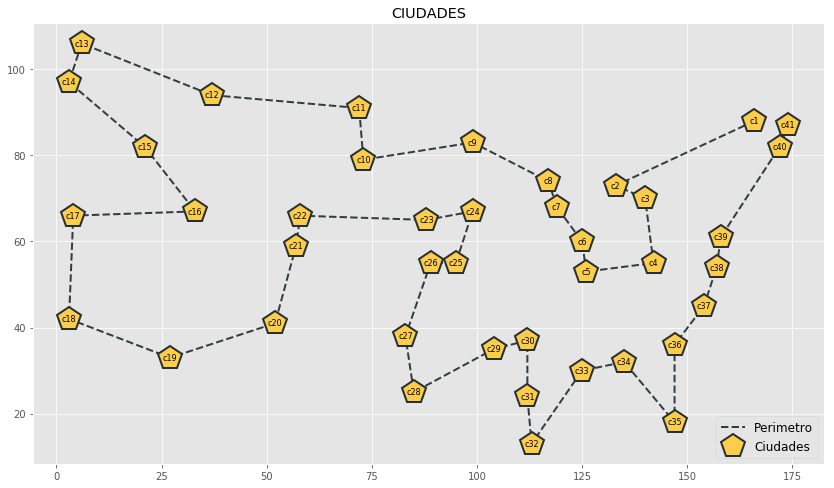

In [3]:
graficar_mapa(ma_cities,ma_IntercityDistances)


<h2>3. Codificación del algorítmo</h2>
<p>
    Creo las clases, funciones y metodos que requiero para la implementación.
<p/>

In [4]:
#Clase principal para encontrar el camino de menor costo en el problema TSP con ACO
import random
class MenorCostoTSPconACO:
    #Subcclase Edge, objeto de tipo borde que almacena el objeto self, nodo a , nodo b, distancía entre ab, y la feromona de la conexión 
    class Edge:
        # Defino los atributos iniciales por defecto para la clase Edge
        def __init__(self, a, b, distancia, fermona_inicial):
            self.a = a
            self.b = b
            self.distancia = distancia
            self.feromona = fermona_inicial
    #Subclase Hormiga
    class Hormiga:
        #Atributos por defecto
        def __init__(self, alpha, beta, num_nodos, edges):
            self.alpha = alpha
            self.beta = beta
            self.num_nodos = num_nodos
            self.edges = edges
            self.tour = None
            self.distancia_recorrida = 0.0
            
        #Metodo para elegir nodo siguiente a visitar, valida que ya no lo haya visitado.
        def _select_nodo(self):
            ruleta = 0.0 #inicio la ruleta en cero, elige camino al azar
            nodos_no_visitados = [nodo for nodo in range(self.num_nodos) if nodo not in self.camino] #guardo los no visitados
            heuristica_total = 0.0 #Aumento de la distancia del camino
            for nodo_no_visitado in nodos_no_visitados:
                heuristica_total += self.edges[self.camino[-1]][nodo_no_visitado].distancia 
            for nodo_no_visitado in nodos_no_visitados:
                ruleta += pow(self.edges[self.camino[-1]][nodo_no_visitado].feromona, self.alpha) * \
                                  pow((heuristica_total / self.edges[self.camino[-1]][nodo_no_visitado].distancia), self.beta)
            random_value = random.uniform(0.0, ruleta)
            ruleta_pos = 0.0
            for nodo_no_visitado in nodos_no_visitados:
                ruleta_pos += pow(self.edges[self.camino[-1]][nodo_no_visitado].feromona, self.alpha) * \
                                  pow((heuristica_total / self.edges[self.camino[-1]][nodo_no_visitado].distancia), self.beta)
                if ruleta_pos >= random_value:
                    return nodo_no_visitado
        #Metodo para encontrar el camino a elegir
        def encontrar_camino(self):
            self.camino = [random.randint(0, self.num_nodos - 1)]
            while len(self.camino) < self.num_nodos:
                self.camino.append(self._select_nodo())
            return self.camino
        #Distancía entre un nodo y otro
        def get_distancia_recorrida(self):
            self.distancia_recorrida = 0.0
            for i in range(self.num_nodos):
                self.distancia_recorrida += self.edges[self.camino[i]][self.camino[(i + 1) % self.num_nodos]].distancia
            return self.distancia_recorrida
        
        
    # Definición de los atributos para los objetos de la clase MenorCostoTSPconACO
    def __init__(self, modo='ACS', nro_hormigas=10, alpha=1.0, beta=3.0, rho=0.1, 
                 fermona_depositada=1.0, fermona_inicial=1.0, pasos=100, v_nodos=None, m_distancia=None, mensajes=None):
        self.modo = modo
        self.nro_hormigas = nro_hormigas
        self.rho = rho
        self.fermona_depositada = fermona_depositada
        self.pasos = pasos
        self.num_nodos = len(v_nodos)
        self.v_nodos = v_nodos
        if mensajes is not None:
            self.mensajes = mensajes
        else:
            self.mensajes = range(1, self.num_nodos + 1)
        #Declaro la lista de bordes(edges) vacia
        self.edges = [[None] * self.num_nodos for _ in range(self.num_nodos)]
        #Creo un objeto edge(borde) por cada tupla i=a j=b y lo guardo en la lista de bordes, al final se crea una matriz de nxn, con n=número de nodos
        for i in range(self.num_nodos):
            for j in range(self.num_nodos):
                self.edges[i][j] = self.edges[j][i] = self.Edge(i, j, m_distancia[i][j],fermona_inicial) #Guarda objetos del tipo Endge en la lista edges
        self.hormigas = [self.Hormiga(alpha, beta, self.num_nodos, self.edges) for _ in range(self.nro_hormigas)] #Crea las hormigas en una matriz compuesta de objetos de la clase Ant
        self.mejor_camino = None #Atributo en donde guardo el mejor camino
        self.mejor_distancia = float("inf") # Atributo para la distancia minima
    
    #Metodo que agrega feromonas al camino 
    def _agregar_feromona(self, camino, distancia, weight=1.0):
        feromona_agregar= self.fermona_depositada / distancia
        for i in range(self.num_nodos):
            self.edges[camino[i]][camino[(i + 1) % self.num_nodos]].feromona += distancia * feromona_agregar
    #Ciclo de ACS de cada hormida 
    def _acs(self):
        for paso in range(self.pasos):
            for hormiga in self.hormigas:
                self._agregar_feromona(hormiga.encontrar_camino(), hormiga.get_distancia_recorrida())
                if hormiga.distancia_recorrida < self.mejor_distancia:
                    self.mejor_camino = hormiga.camino
                    self.mejor_distancia = hormiga.distancia_recorrida
            for i in range(self.num_nodos):
                for j in range(i + 1, self.num_nodos):
                    self.edges[i][j].feromona *= (1.0 - self.rho)
    #Metodo que se carga al correr la clase
    def run(self):
        self._acs()

            
    #Grafico los resultados
    def plot(self, line_width=1, point_radius=math.sqrt(2.0), annotation_size=10, dpi=120, save=True, name=None):
        fig = plt.figure(figsize=(15.75,9))
        x = [self.v_nodos[i][0] for i in self.mejor_camino]
        x.append(x[0])
        y = [self.v_nodos[i][1] for i in self.mejor_camino]
        y.append(y[0])
        #Imprimo la línea
        plt.plot( x, y, '--',x, y, 'p',color='#353C3F',#color de la línea
             markersize=25, #Tamaño del punto
             linewidth=2,
             markerfacecolor='#FBCD4B',#Color por dentro del punto
             markeredgecolor='#262F34',#Color del borde del punto
             markeredgewidth=2)#Grosor del borde del punto
        
        #Variaciones del ejercicio - Creo un parche para poner en la parte superior derecha de la imagen
        handle1 = mpatches.Patch(color='white', label='Hormigas: '+str(self.nro_hormigas))
        handle2 = mpatches.Patch(color='white', label='Pasos: '+str(self.pasos))
        handle3 = mpatches.Patch(color='white', label='Rho: '+str(self.rho))
        ax = plt.gca().add_artist(plt.legend(handles=[handle1,handle2,handle3],prop = {'size': 12}))
        
        #Resultado
        handle4 = mpatches.Patch(color='white', label='Distancia recorrida: '+str(round(self.mejor_distancia, 2)))
        ax = plt.gca().add_artist(plt.legend(handles=[handle4],prop = {'size': 12},loc='lower left'))
        
        #Datos de la gráfica 
        plt.title(" Ruta encontrada con ACS - "+self.modo)
        legend(("Camino","Ciudades"), prop = {'size': 12}, loc='lower right')
        plt.grid(True)
        
        #Identificador de ciudades (número de cada ciudad)
        for i in self.mejor_camino:
            plt.annotate("c"+str(i+1),
                         size=8, 
                         xy=self.v_nodos[i],
                         horizontalalignment='center',
                         verticalalignment='center') #Caja en la anotación bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1')
        plt.show()
        return self.mejor_distancia



<h2>4. Impementación</h2>
<p>
    Implementamos el algorítmo con N configuraciones para luego seleccionar y documentamos los 3 mejores resultado.
<p/>

In [4]:
# Defino una función para el envío de las diferentes configuraciones de forma ordenada
def implementar(tipo, nh, vueltas, t_evap):
    acs = MenorCostoTSPconACO(modo=tipo, nro_hormigas=nh, pasos=vueltas, v_nodos=ma_cities, m_distancia=ma_IntercityDistances, rho=t_evap)
    acs.run()
    distancia_camino_final = acs.plot()
    return distancia_camino_final
    
#Se definen diferentes configuraciones para el informe
txt_config=[] #Texto de la configuración
nro_hormigas=[] #tamaño de la colonia
pasos=[] # nro de pasos totales
rho=[] # tasa de evaporación de las fermonas ENTRE 0 y 1
txt_config.append('Configuración 1'); nro_hormigas.append(50); pasos.append(10); rho.append(0.1);
txt_config.append('Configuración 2'); nro_hormigas.append(100); pasos.append(10); rho.append(0.1);
txt_config.append('Configuración 3'); nro_hormigas.append(150); pasos.append(10); rho.append(0.1);
txt_config.append('Configuración 4'); nro_hormigas.append(50); pasos.append(30); rho.append(0.5);
txt_config.append('Configuración 5'); nro_hormigas.append(100); pasos.append(30); rho.append(0.5);
txt_config.append('Configuración 6'); nro_hormigas.append(150); pasos.append(30); rho.append(0.5);
txt_config.append('Configuración 7'); nro_hormigas.append(50); pasos.append(50); rho.append(0.1);
txt_config.append('Configuración 8'); nro_hormigas.append(100); pasos.append(50); rho.append(0.1);
txt_config.append('Configuración 9'); nro_hormigas.append(150); pasos.append(50); rho.append(0.1);
txt_config.append('Configuración 10');nro_hormigas.append(50); pasos.append(100); rho.append(0.5);
txt_config.append('Configuración 11'); nro_hormigas.append(100); pasos.append(100); rho.append(0.5);
txt_config.append('Configuración 12'); nro_hormigas.append(150); pasos.append(100); rho.append(0.5);

<h2>5. Visualización de resultados</h2>
<p>
    Imprimimos los resultados de todas las configuraciones para revisar cuales son las 3 mejores.
<p/>

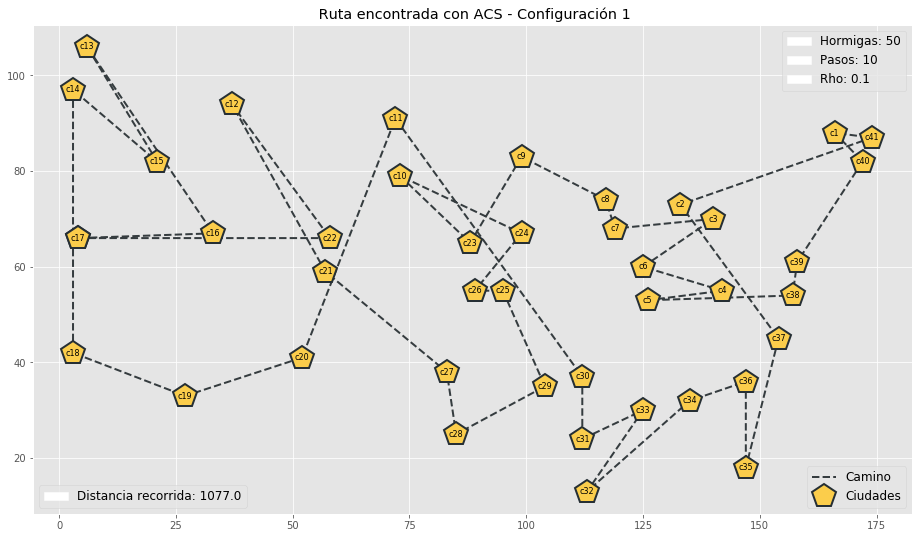

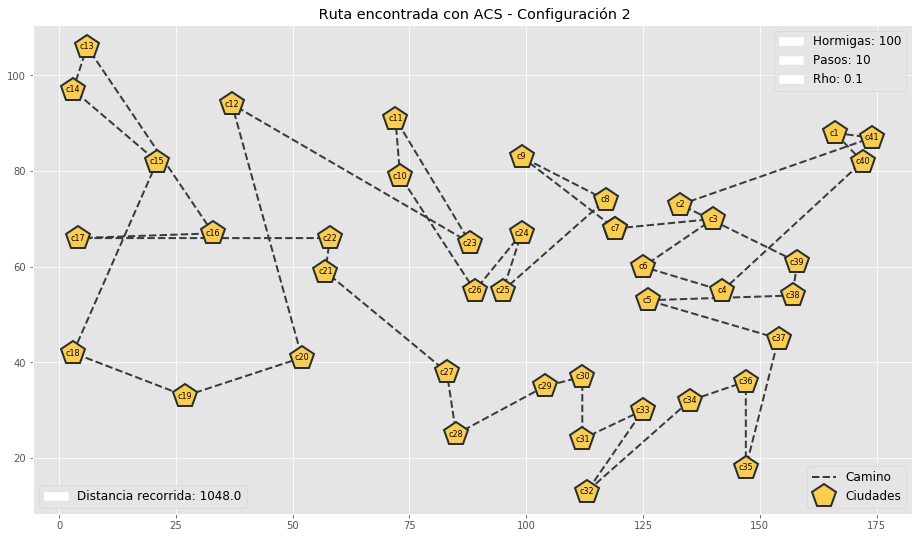

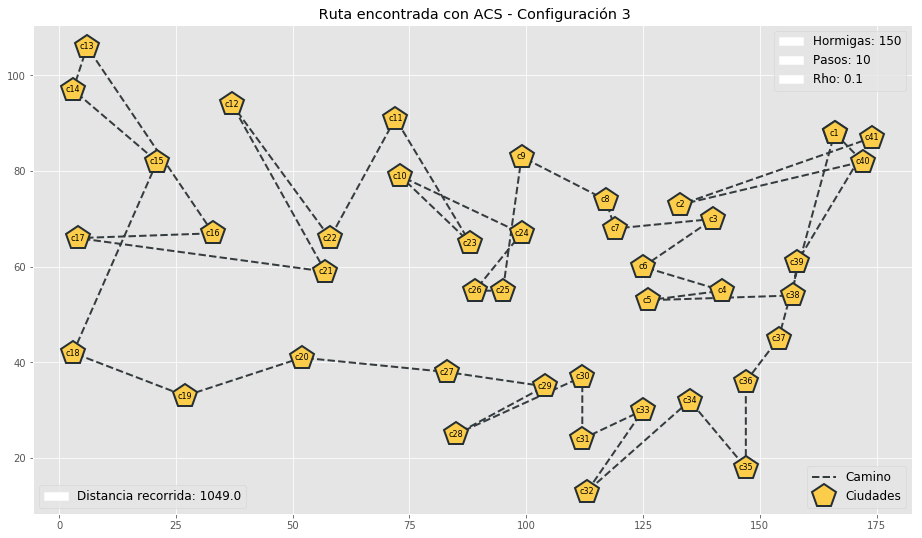

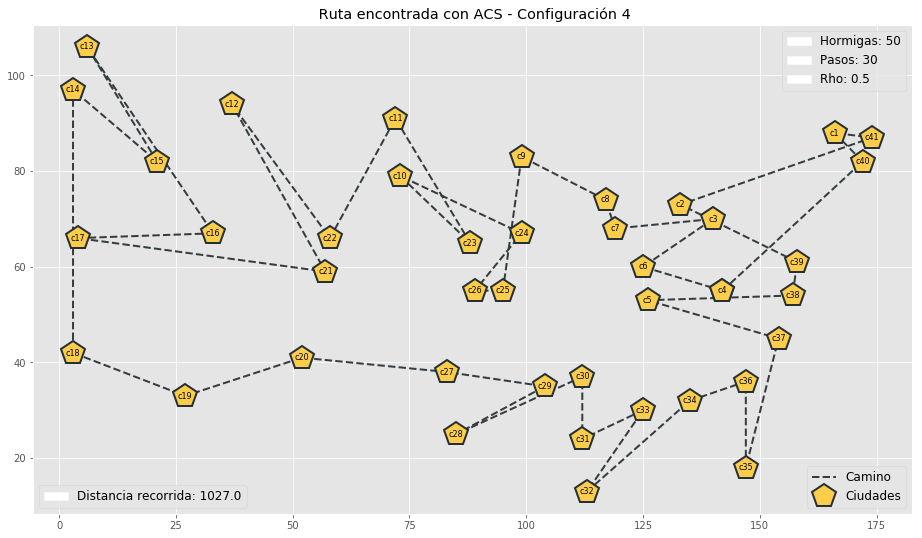

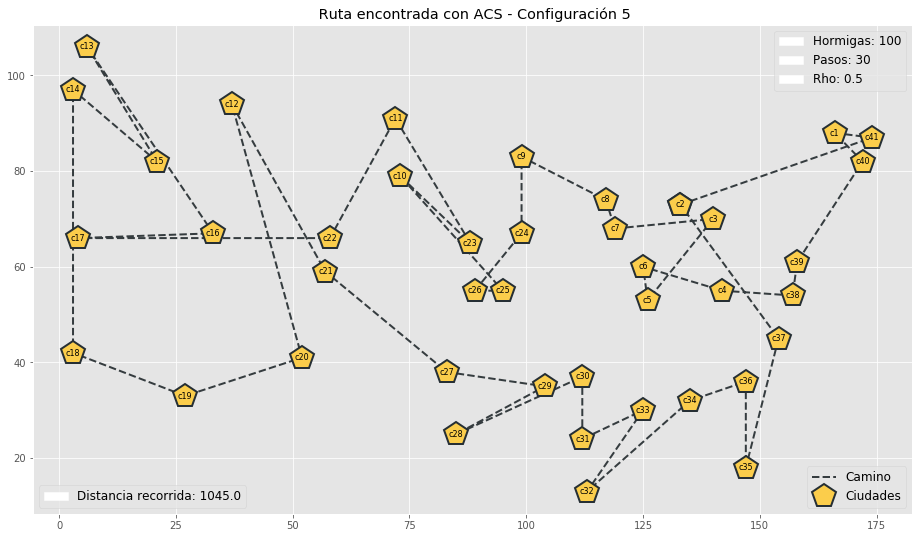

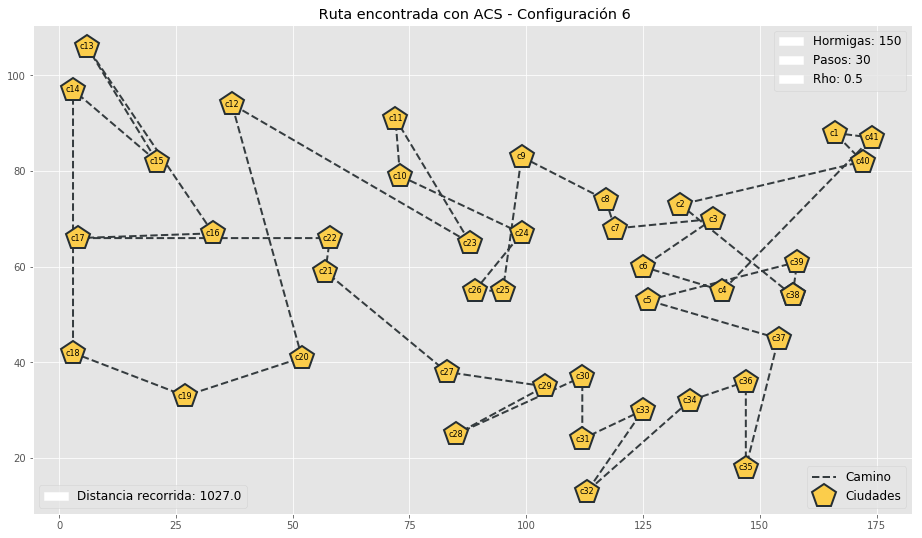

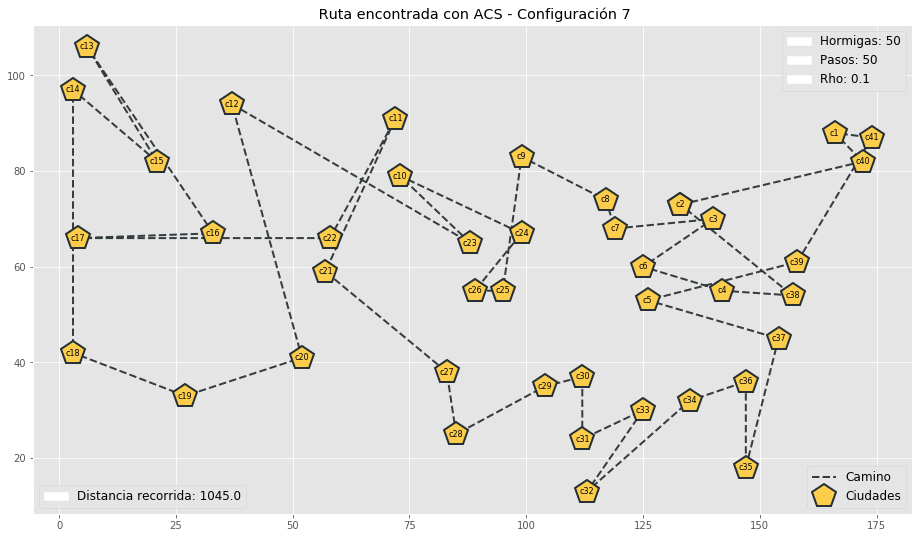

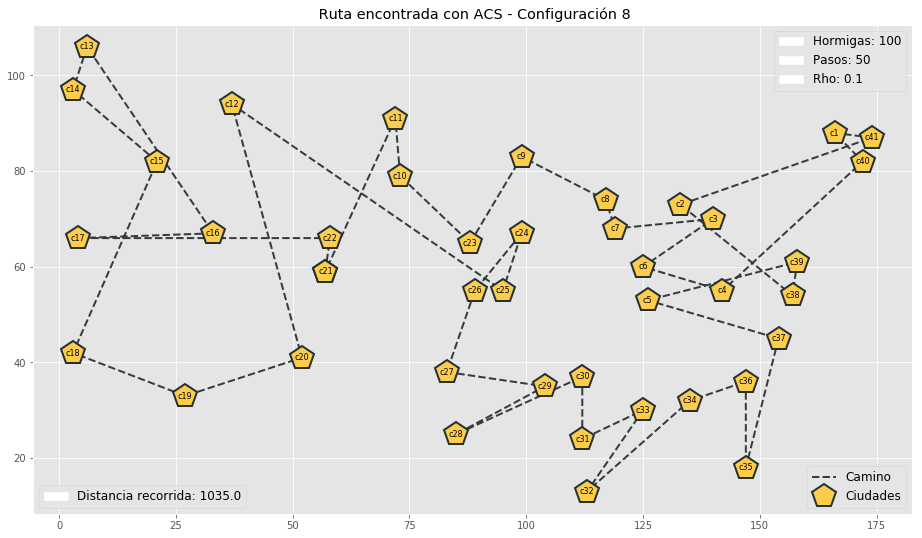

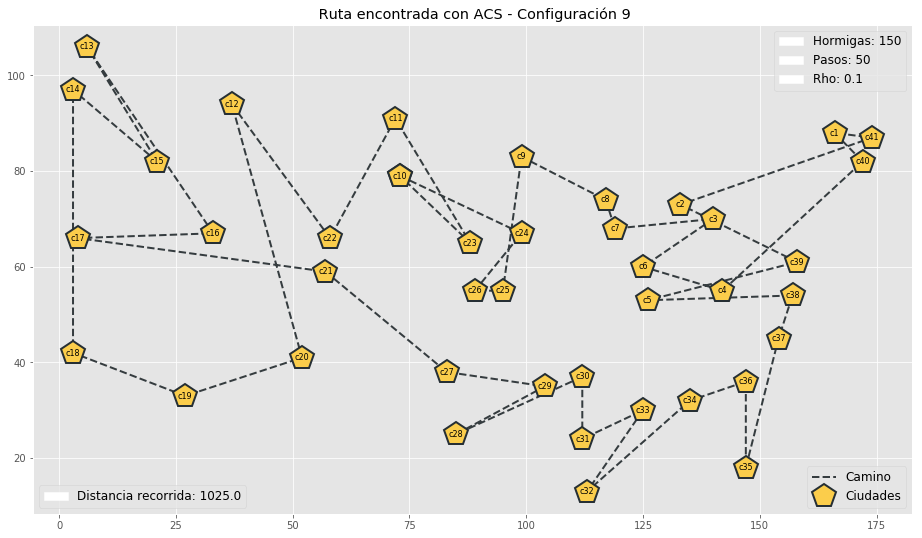

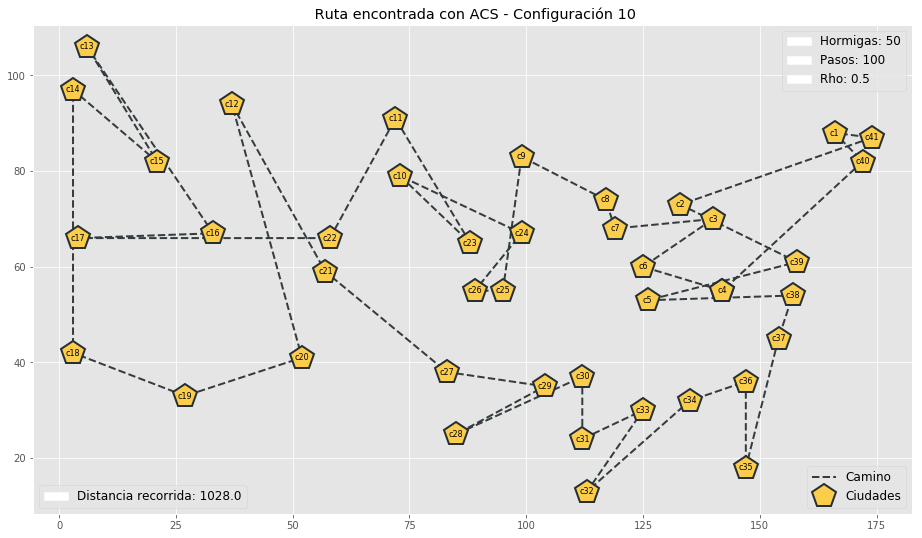

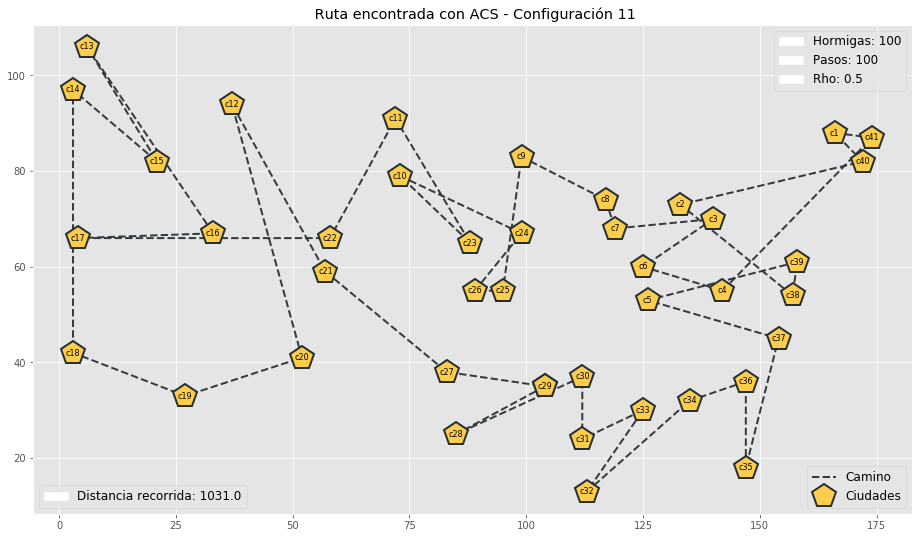

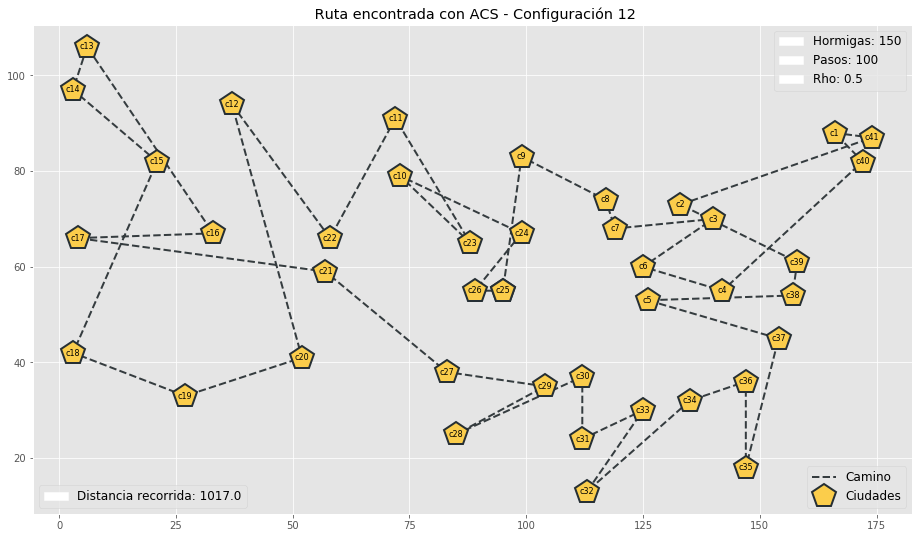

In [5]:
distancia=[]# Vector de discancias finales en cada configuración
tiempo=[]# Vector de tiempos de ejecución del algorítmo en cada configuración
for i in range(len(txt_config)):
    start_time = time()
    distancia.append(implementar(txt_config[i], nro_hormigas[i], pasos[i], rho[i]))
    tiempo.append(time()-start_time)

<h2>6. Selección de los mejores resultado</h2>
<p>
Para esto hacemos una gráfica de resultados con las distancias totales de las configuraciones realizadas, basados en esta información seleccionamos las tres menores distancias.
<p/>

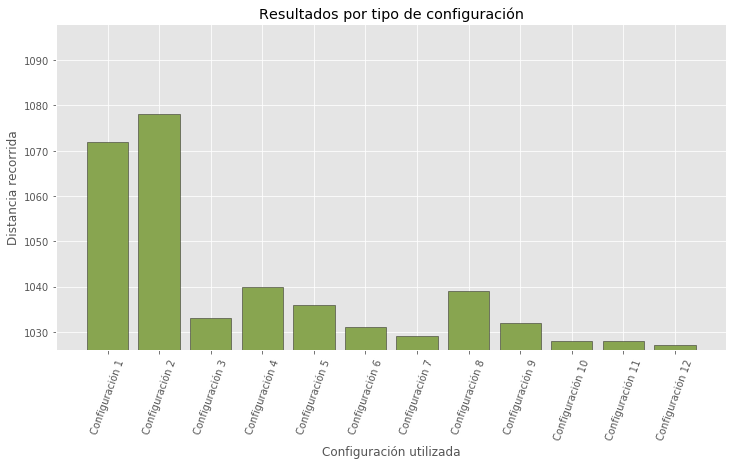

In [7]:
# Creamos la gráfica de barras, le enviamos el vector de distancias obtenido, en donde su indice+1 corresponde a la configuración
plt.style.use('ggplot')
fig = plt.figure(figsize=(12,6))
plt.bar(range(len(distancia)), distancia, edgecolor='#282623', color='#88A550')#'#FBCD4B'
plt.xticks(range(len(distancia)), txt_config, rotation=70)
plt.ylim(min(distancia)-1, max(distancia)+20)
plt.title("Resultados por tipo de configuración")
plt.ylabel('Distancia recorrida')
plt.xlabel('Configuración utilizada')
plt.show()

<p>
Selecciono sólo 3 configuraciones de las opciones realizadas:
<p/>

<h2>7. Análisis a los mejores 3 resultado</h2>
<p>
Ordeno el vector distancia de menor a mayor para hacer la comparación sólo de los tres mejores resultados
<p/>

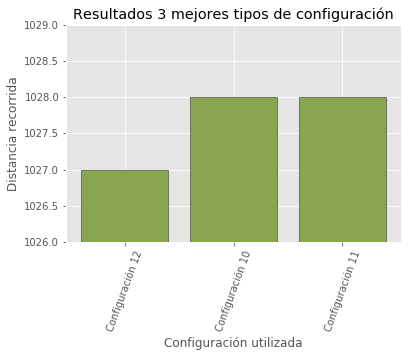

In [13]:
#Primero guardo sus indices para saber la ubicación
index1=distancia.index(sorted(distancia,reverse=False)[0])
index2=distancia.index(sorted(distancia,reverse=False)[1])
index3=distancia.index(sorted(distancia,reverse=False)[2])
if index2==index1:
    index2=index2+1
if index2==index3:
    index3=index3+1
plt.style.use('ggplot')
fig = plt.figure()
plt.bar(range(3),sorted(distancia,reverse=False)[0:3], edgecolor='#282623', color='#88A550')# Ordeno de menor a mayor la distancia y selecciono sólo los primero 3
plt.xticks(range(3),(txt_config[index1],txt_config[index2],txt_config[index3]), rotation=70)
plt.ylim(min(distancia[index1],distancia[index2],distancia[index3])-1, max(distancia[index1],distancia[index2],distancia[index3])+1)
plt.title("Resultados 3 mejores tipos de configuración")
plt.ylabel('Distancia recorrida')
plt.xlabel('Configuración utilizada')
plt.show()

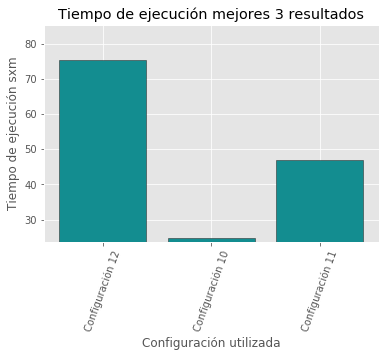

In [14]:
plt.style.use('ggplot')
fig = plt.figure()
plt.bar(range(3),(tiempo[index1],tiempo[index2],tiempo[index3]), edgecolor='#282623', color='#138d90')# Ordeno de menor a mayor la distancia y selecciono sólo los primero 3
plt.xticks(range(3),(txt_config[index1],txt_config[index2],txt_config[index3]), rotation=70)
plt.ylim(min(tiempo[index1],tiempo[index2],tiempo[index3])-1, max(tiempo[index1],tiempo[index2],tiempo[index3])+10)
plt.title("Tiempo de ejecución mejores 3 resultados")
plt.ylabel('Tiempo de ejecución sxm')
plt.xlabel('Configuración utilizada')
plt.show()


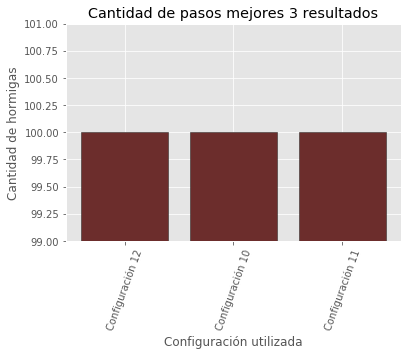

In [15]:
plt.style.use('ggplot')
fig = plt.figure()
plt.bar(range(3),(pasos[index1],pasos[index2],pasos[index3]), edgecolor='#282623', color='#6C2D2C')# Ordeno de menor a mayor la distancia y selecciono sólo los primero 3
plt.xticks(range(3),(txt_config[index1],txt_config[index2],txt_config[index3]), rotation=70)
plt.ylim(min(pasos[index1],pasos[index2],pasos[index3])-1, max(pasos[index1],pasos[index2],pasos[index3])+1)
plt.title("Cantidad de pasos mejores 3 resultados")
plt.ylabel('Cantidad de hormigas')
plt.xlabel('Configuración utilizada')
plt.show()


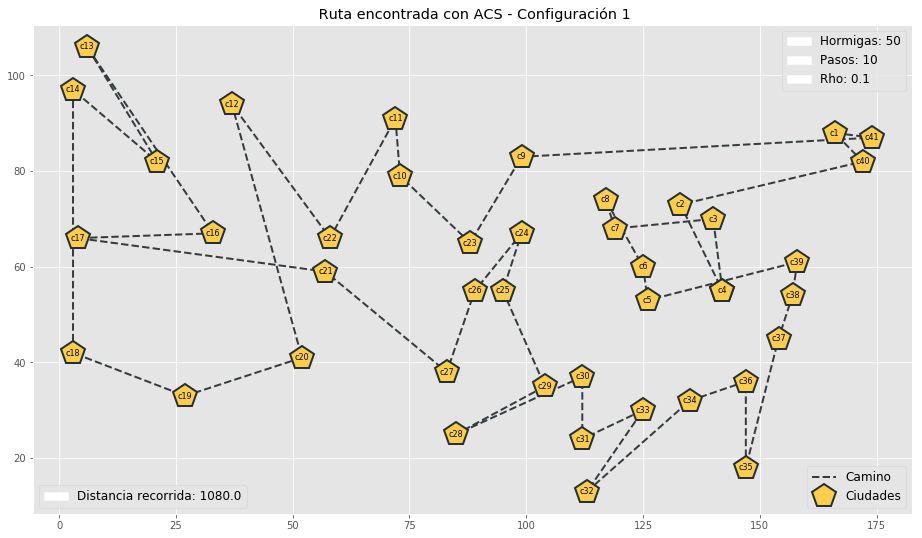

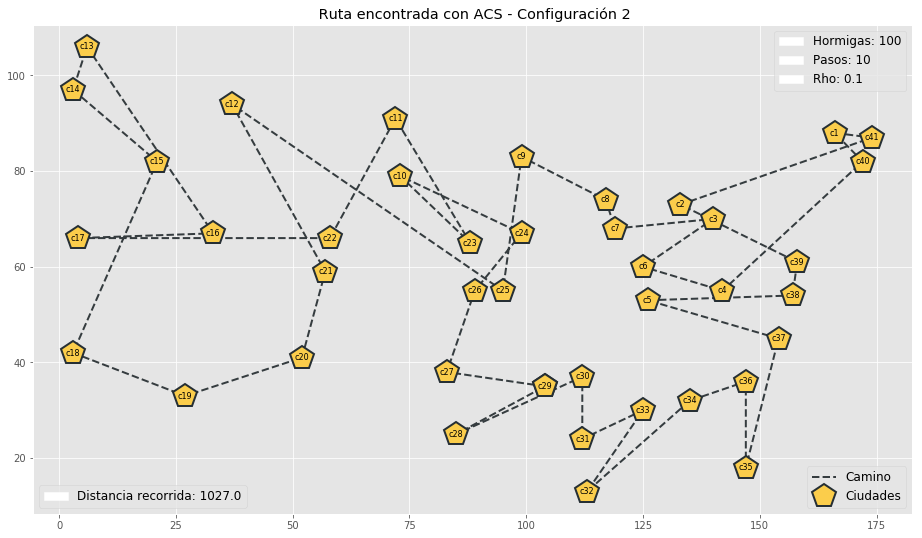

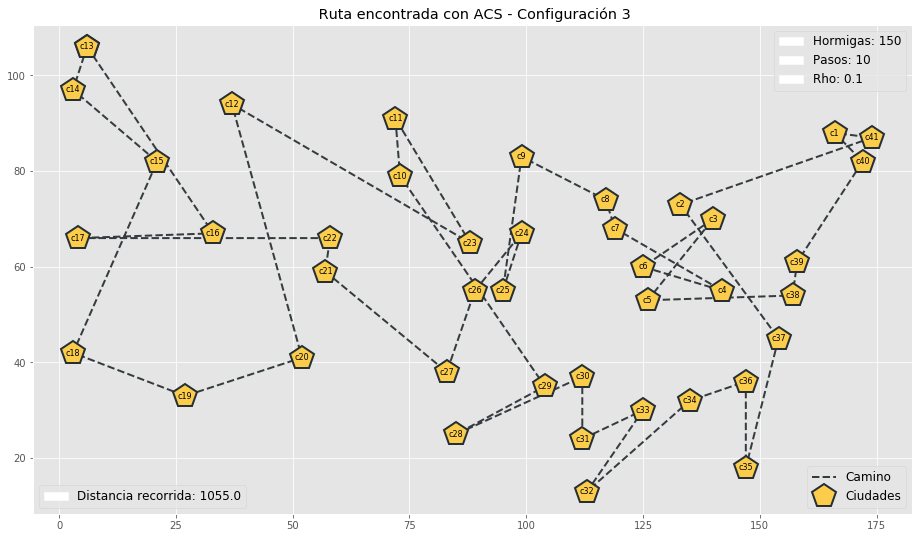

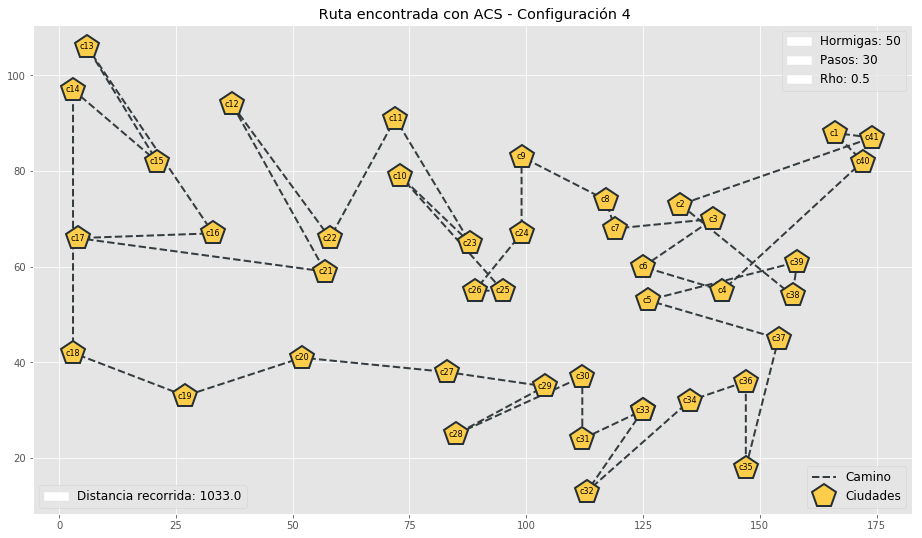

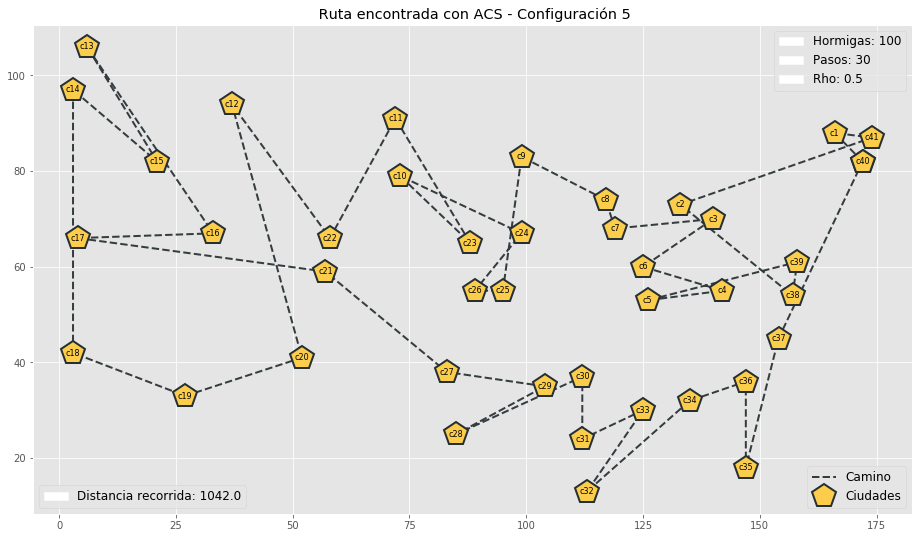

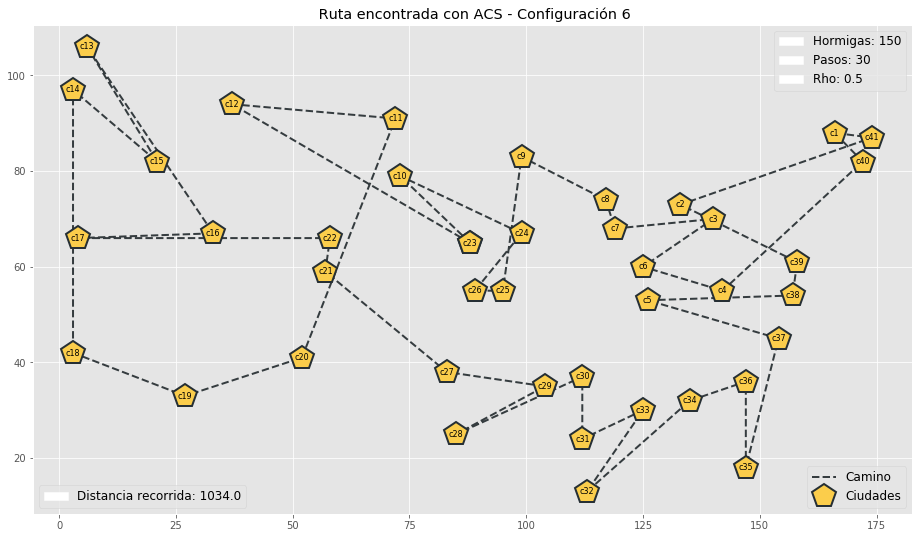

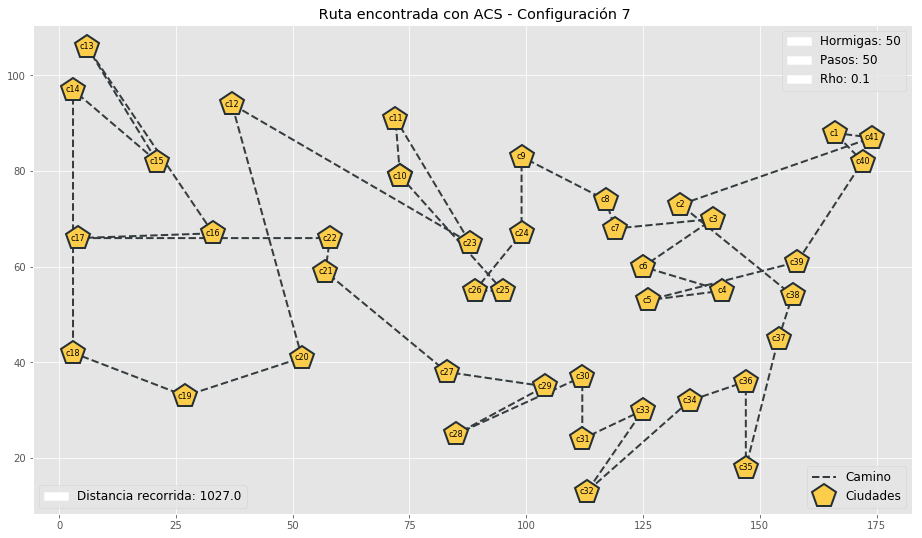

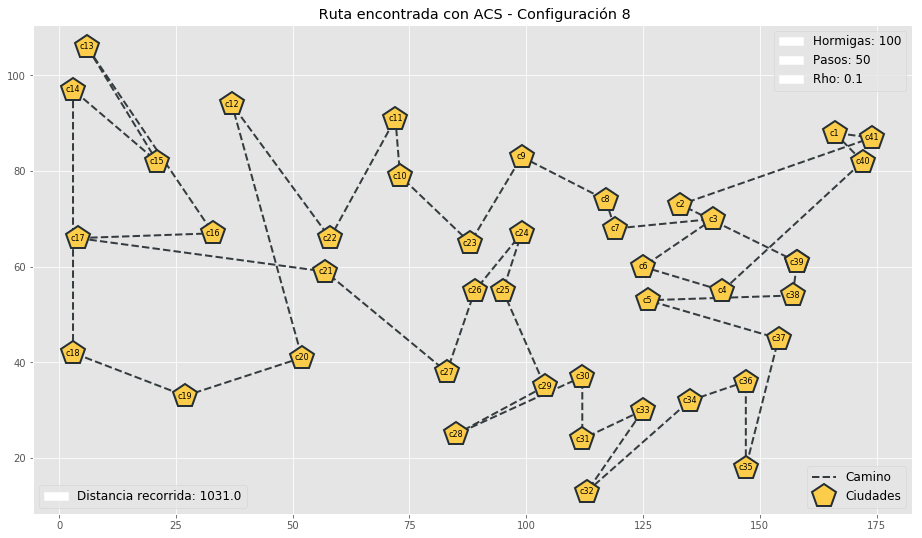

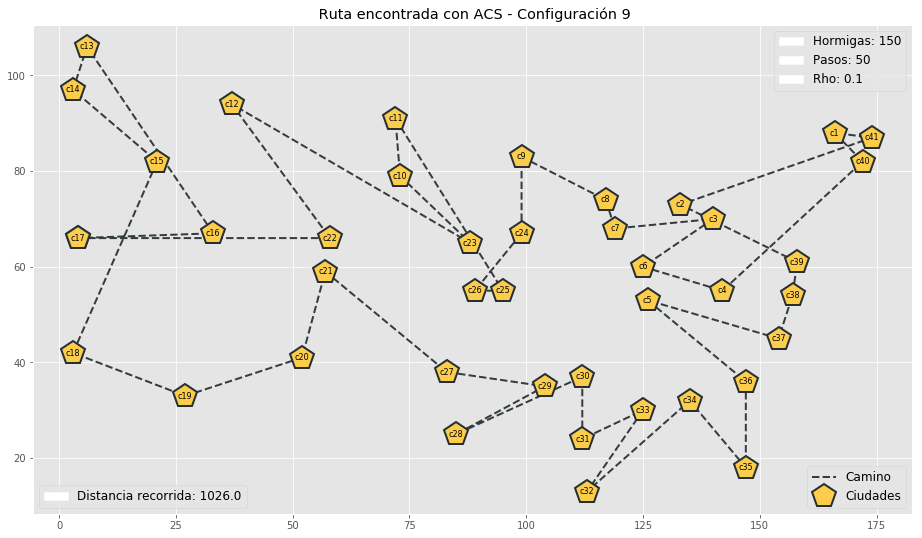

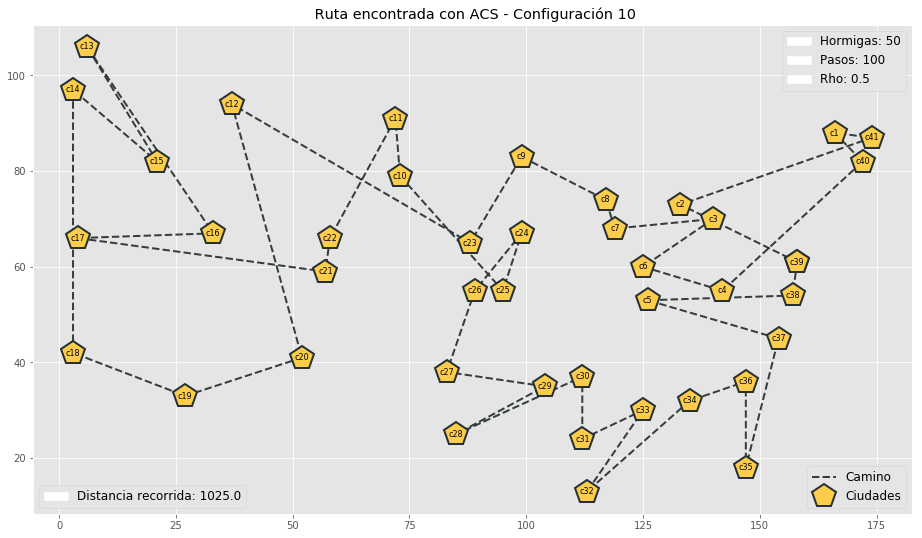

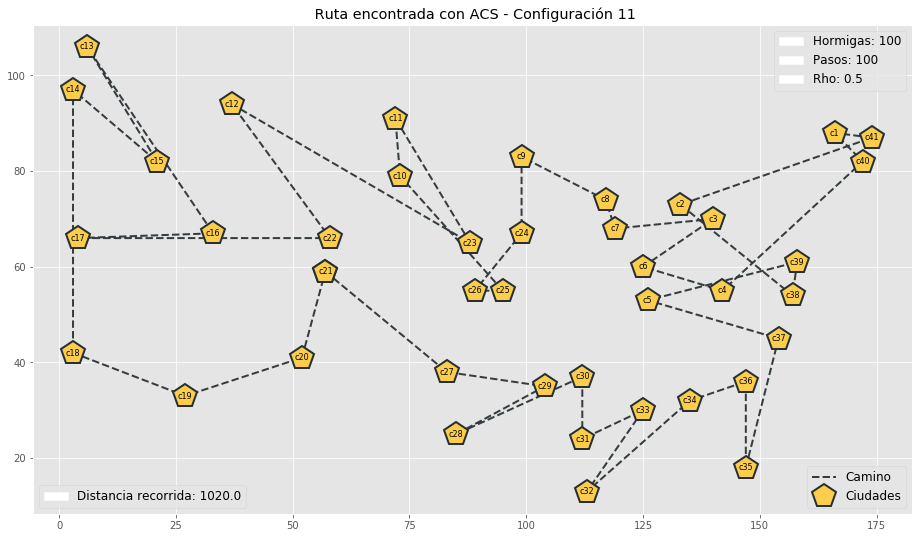

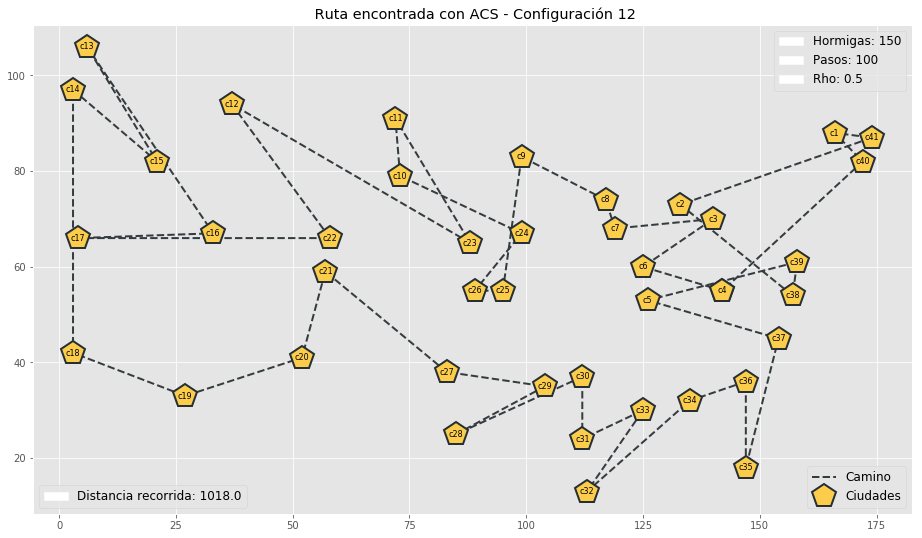

In [5]:
distancia=[]# Vector de discancias finales en cada configuración
tiempo=[]# Vector de tiempos de ejecución del algorítmo en cada configuración
for i in range(len(txt_config)):
    start_time = time()
    distancia.append(implementar(txt_config[i], nro_hormigas[i], pasos[i], rho[i]))
    tiempo.append(time()-start_time)

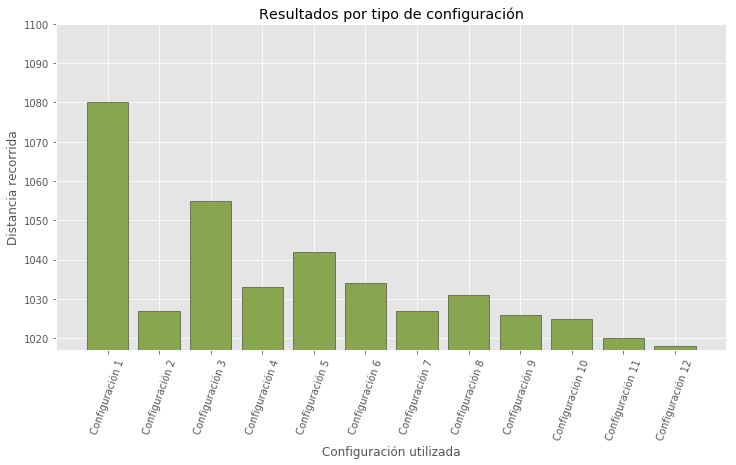

In [6]:
# Creamos la gráfica de barras, le enviamos el vector de distancias obtenido, en donde su indice+1 corresponde a la configuración
plt.style.use('ggplot')
fig = plt.figure(figsize=(12,6))
plt.bar(range(len(distancia)), distancia, edgecolor='#282623', color='#88A550')#'#FBCD4B'
plt.xticks(range(len(distancia)), txt_config, rotation=70)
plt.ylim(min(distancia)-1, max(distancia)+20)
plt.title("Resultados por tipo de configuración")
plt.ylabel('Distancia recorrida')
plt.xlabel('Configuración utilizada')
plt.show()

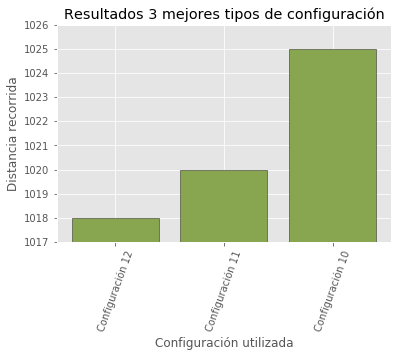

In [7]:
#Primero guardo sus indices para saber la ubicación
index1=distancia.index(sorted(distancia,reverse=False)[0])
index2=distancia.index(sorted(distancia,reverse=False)[1])
index3=distancia.index(sorted(distancia,reverse=False)[2])
if index2==index1:
    index2=index2+1
if index2==index3:
    index3=index3+1
plt.style.use('ggplot')
fig = plt.figure()
plt.bar(range(3),sorted(distancia,reverse=False)[0:3], edgecolor='#282623', color='#88A550')# Ordeno de menor a mayor la distancia y selecciono sólo los primero 3
plt.xticks(range(3),(txt_config[index1],txt_config[index2],txt_config[index3]), rotation=70)
plt.ylim(min(distancia[index1],distancia[index2],distancia[index3])-1, max(distancia[index1],distancia[index2],distancia[index3])+1)
plt.title("Resultados 3 mejores tipos de configuración")
plt.ylabel('Distancia recorrida')
plt.xlabel('Configuración utilizada')
plt.show()

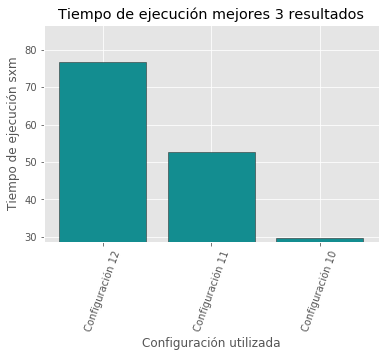

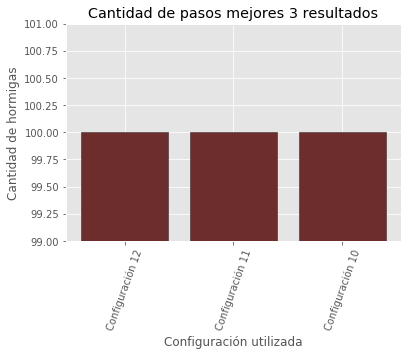

In [8]:
plt.style.use('ggplot')
fig = plt.figure()
plt.bar(range(3),(tiempo[index1],tiempo[index2],tiempo[index3]), edgecolor='#282623', color='#138d90')# Ordeno de menor a mayor la distancia y selecciono sólo los primero 3
plt.xticks(range(3),(txt_config[index1],txt_config[index2],txt_config[index3]), rotation=70)
plt.ylim(min(tiempo[index1],tiempo[index2],tiempo[index3])-1, max(tiempo[index1],tiempo[index2],tiempo[index3])+10)
plt.title("Tiempo de ejecución mejores 3 resultados")
plt.ylabel('Tiempo de ejecución sxm')
plt.xlabel('Configuración utilizada')
plt.show()

plt.style.use('ggplot')
fig = plt.figure()
plt.bar(range(3),(pasos[index1],pasos[index2],pasos[index3]), edgecolor='#282623', color='#6C2D2C')# Ordeno de menor a mayor la distancia y selecciono sólo los primero 3
plt.xticks(range(3),(txt_config[index1],txt_config[index2],txt_config[index3]), rotation=70)
plt.ylim(min(pasos[index1],pasos[index2],pasos[index3])-1, max(pasos[index1],pasos[index2],pasos[index3])+1)
plt.title("Cantidad de pasos mejores 3 resultados")
plt.ylabel('Cantidad de hormigas')
plt.xlabel('Configuración utilizada')
plt.show()

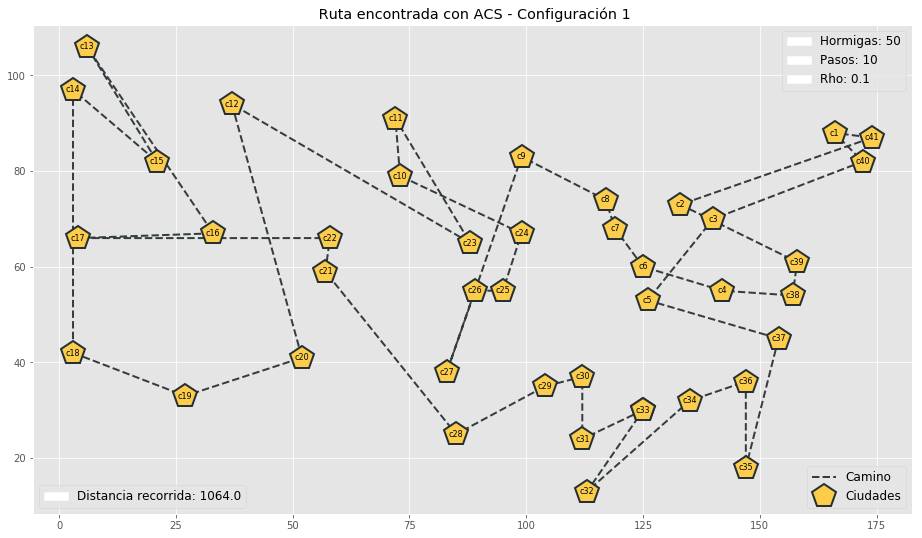

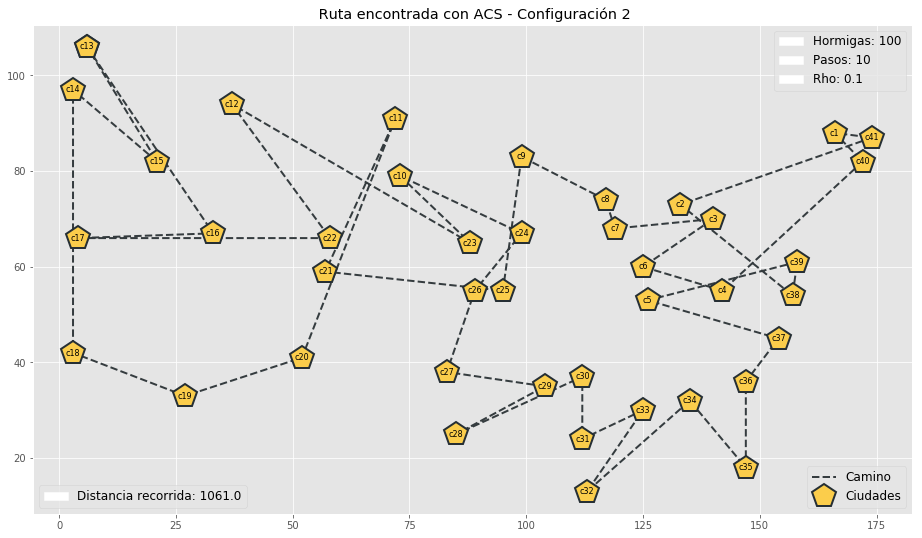

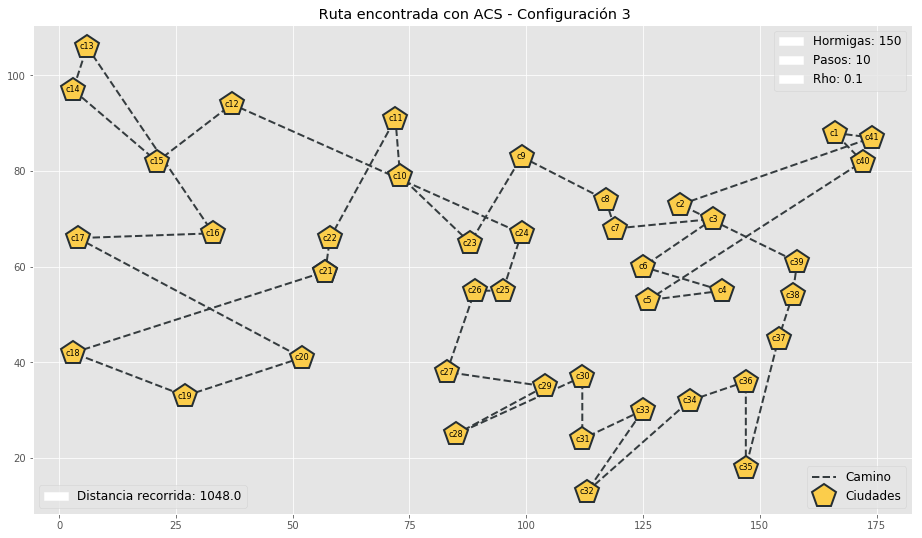

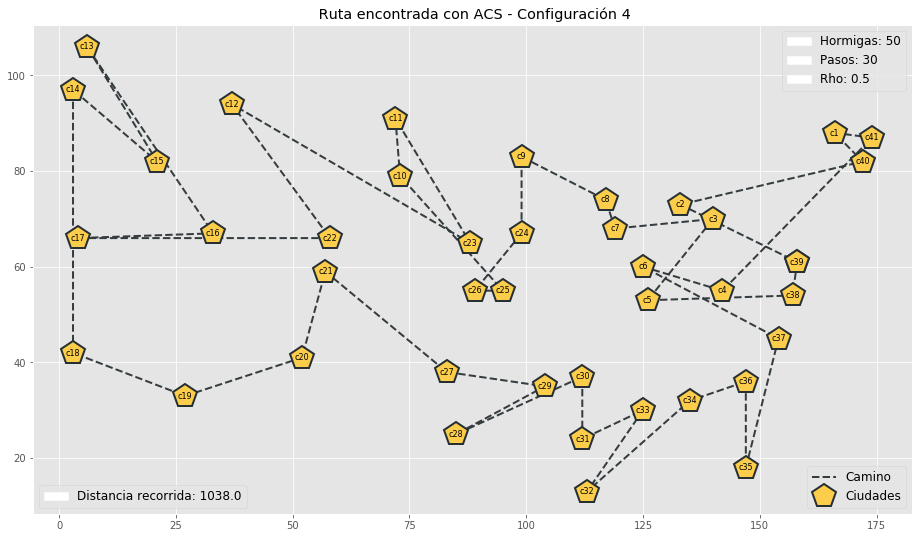

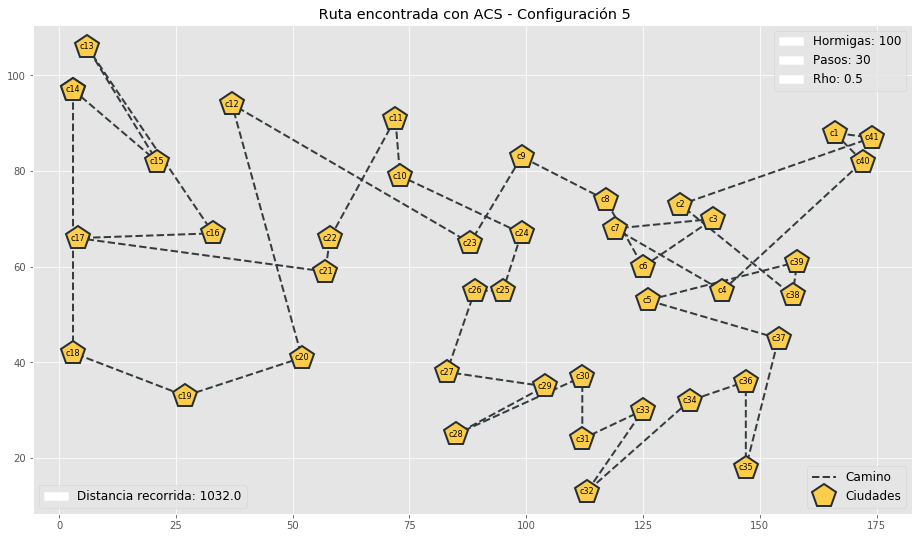

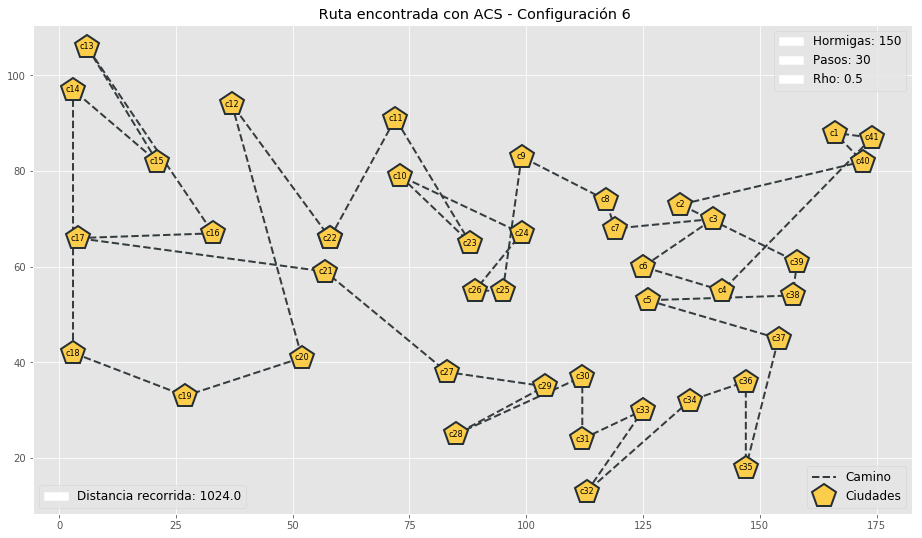

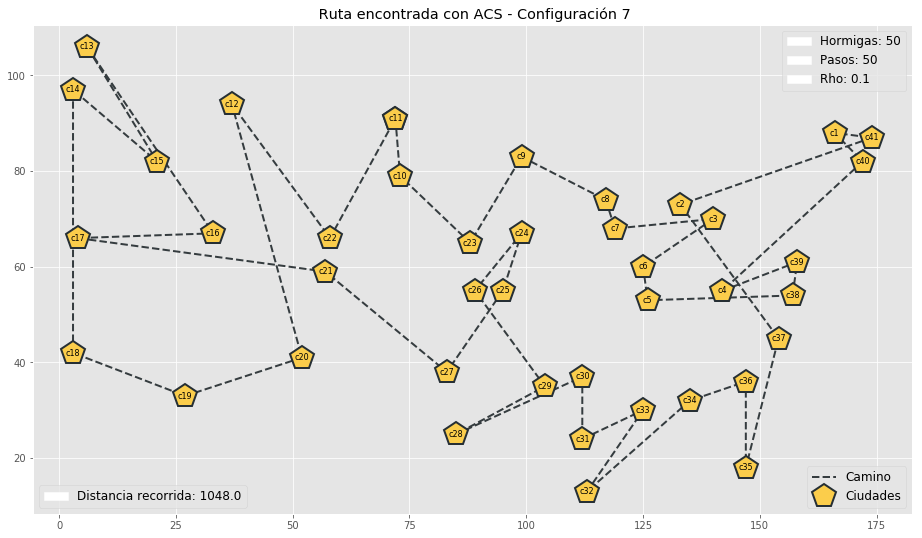

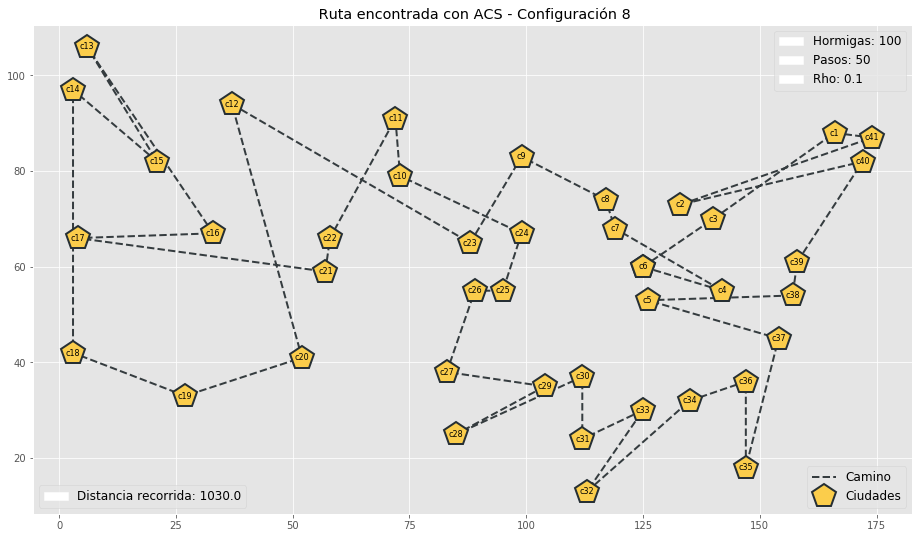

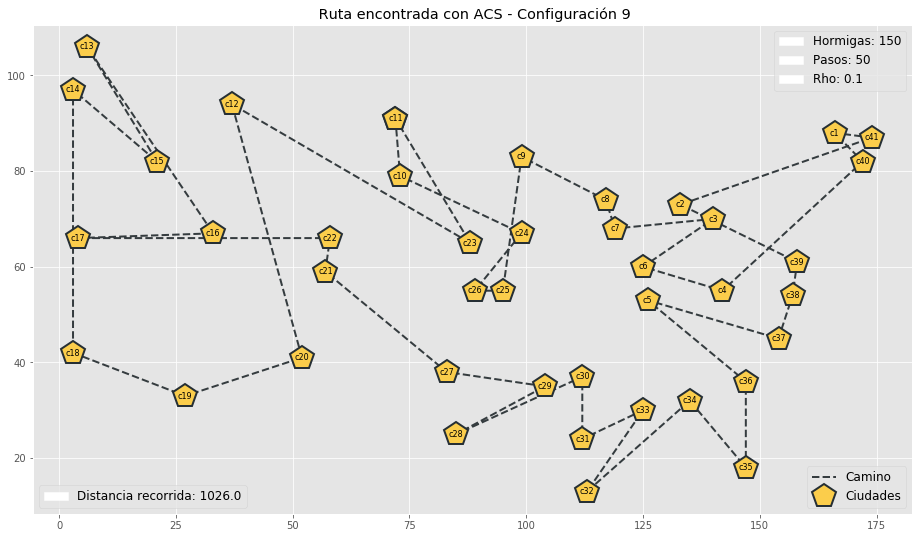

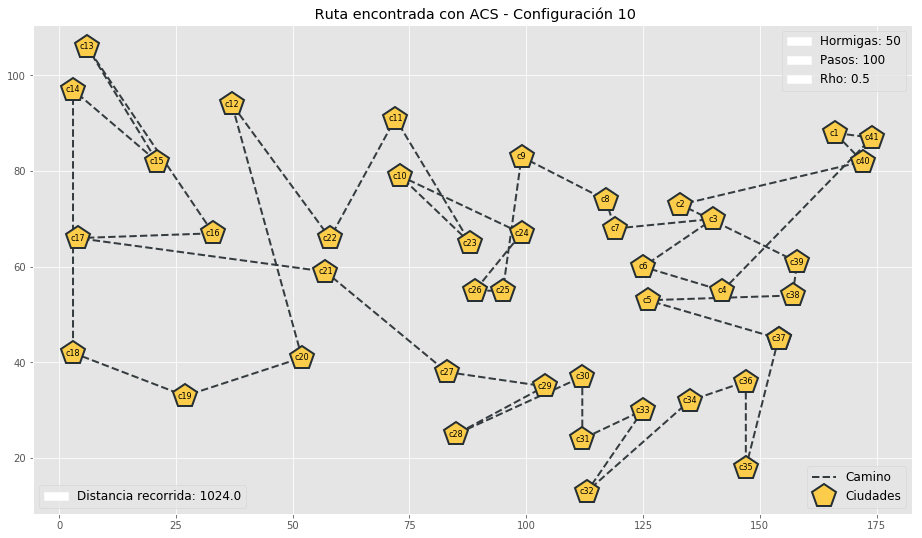

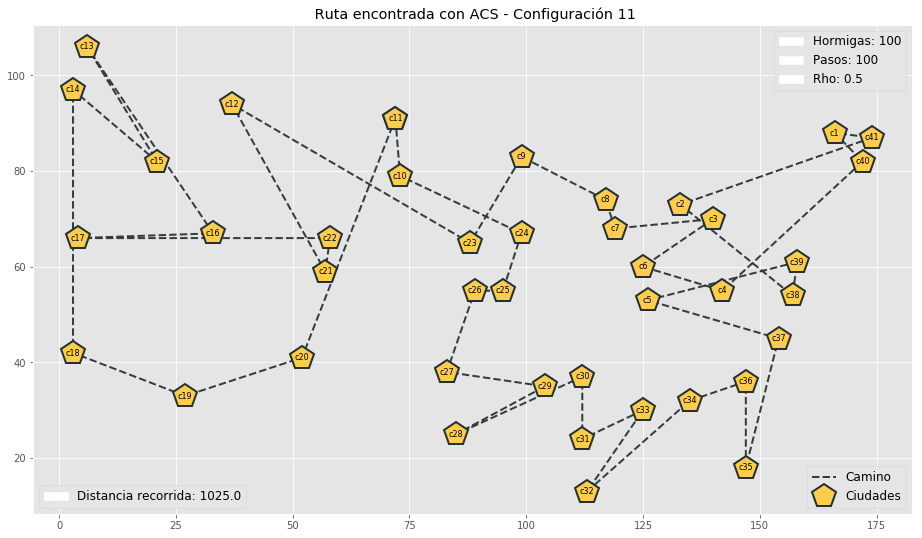

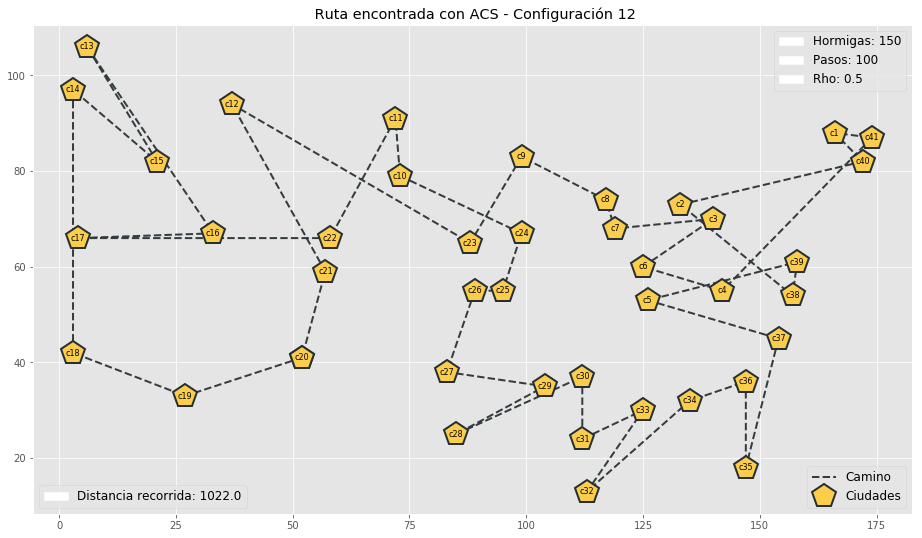

In [5]:
distancia=[]# Vector de discancias finales en cada configuración
tiempo=[]# Vector de tiempos de ejecución del algorítmo en cada configuración
for i in range(len(txt_config)):
    start_time = time()
    distancia.append(implementar(txt_config[i], nro_hormigas[i], pasos[i], rho[i]))
    tiempo.append(time()-start_time)

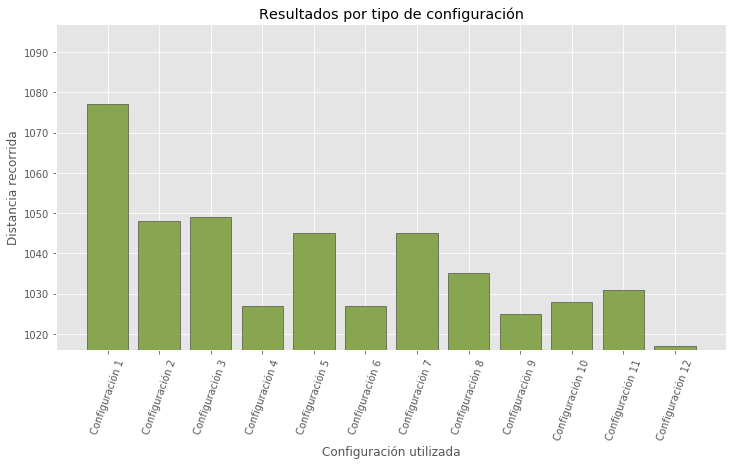

In [6]:
# Creamos la gráfica de barras, le enviamos el vector de distancias obtenido, en donde su indice+1 corresponde a la configuración
plt.style.use('ggplot')
fig = plt.figure(figsize=(12,6))
plt.bar(range(len(distancia)), distancia, edgecolor='#282623', color='#88A550')#'#FBCD4B'
plt.xticks(range(len(distancia)), txt_config, rotation=70)
plt.ylim(min(distancia)-1, max(distancia)+20)
plt.title("Resultados por tipo de configuración")
plt.ylabel('Distancia recorrida')
plt.xlabel('Configuración utilizada')
plt.show()

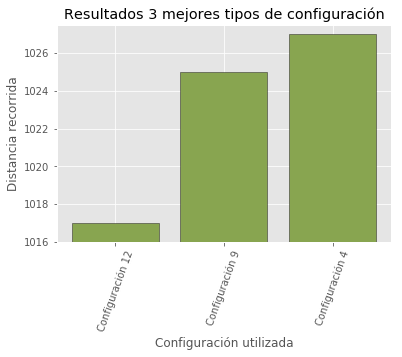

In [7]:
#Primero guardo sus indices para saber la ubicación
index1=distancia.index(sorted(distancia,reverse=False)[0])
index2=distancia.index(sorted(distancia,reverse=False)[1])
index3=distancia.index(sorted(distancia,reverse=False)[2])
if index2==index1:
    index2=index2+1
if index2==index3:
    index3=index3+1
plt.style.use('ggplot')
fig = plt.figure()
plt.bar(range(3),sorted(distancia,reverse=False)[0:3], edgecolor='#282623', color='#88A550')# Ordeno de menor a mayor la distancia y selecciono sólo los primero 3
plt.xticks(range(3),(txt_config[index1],txt_config[index2],txt_config[index3]), rotation=70)
plt.ylim(min(distancia[index1],distancia[index2],distancia[index3])-1, max(distancia[index1],distancia[index2],distancia[index3])+0.5)
plt.title("Resultados 3 mejores tipos de configuración")
plt.ylabel('Distancia recorrida')
plt.xlabel('Configuración utilizada')
plt.show()

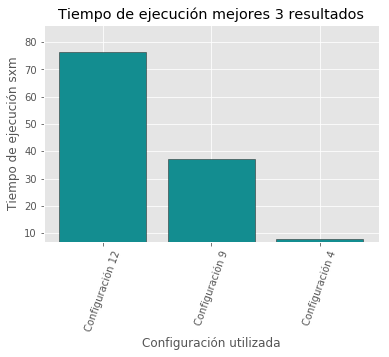

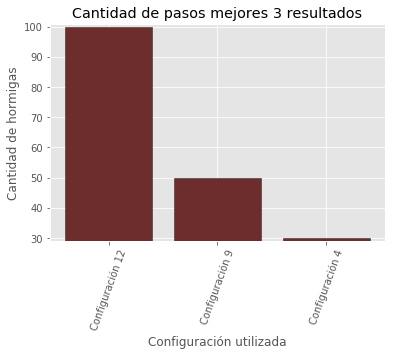

In [8]:
plt.style.use('ggplot')
fig = plt.figure()
plt.bar(range(3),(tiempo[index1],tiempo[index2],tiempo[index3]), edgecolor='#282623', color='#138d90')# Ordeno de menor a mayor la distancia y selecciono sólo los primero 3
plt.xticks(range(3),(txt_config[index1],txt_config[index2],txt_config[index3]), rotation=70)
plt.ylim(min(tiempo[index1],tiempo[index2],tiempo[index3])-1, max(tiempo[index1],tiempo[index2],tiempo[index3])+10)
plt.title("Tiempo de ejecución mejores 3 resultados")
plt.ylabel('Tiempo de ejecución sxm')
plt.xlabel('Configuración utilizada')
plt.show()

plt.style.use('ggplot')
fig = plt.figure()
plt.bar(range(3),(pasos[index1],pasos[index2],pasos[index3]), edgecolor='#282623', color='#6C2D2C')# Ordeno de menor a mayor la distancia y selecciono sólo los primero 3
plt.xticks(range(3),(txt_config[index1],txt_config[index2],txt_config[index3]), rotation=70)
plt.ylim(min(pasos[index1],pasos[index2],pasos[index3])-1, max(pasos[index1],pasos[index2],pasos[index3])+1)
plt.title("Cantidad de pasos mejores 3 resultados")
plt.ylabel('Cantidad de hormigas')
plt.xlabel('Configuración utilizada')
plt.show()